# こちらのデータはタンタンタイガーの数値を基にして作成しておりますが、全てのデータ開示は会社の競争上で問題があるため、売上や単価など一部数値を変更しております。個別にご連絡いただければ開示・ご相談を検討します。

In [63]:
#必要なライブラリを予めすべてインポート
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
sns.set_style('whitegrid')
sns.set(font='AppleMyungjo')


# タンタンタイガーの2017上半期売上分析
## Objective(目的)＆Why (なぜやるのか)
タンタンタイガーの下半期売上データを分析する。
各データから意味を抽出して、売上に影響している要因を見つけ出し、改善アクションにつなげる。

## Data for deep dive (見てみるデータ)
1. 売上・来客数・単価の平均・偏差等のスタッツはどうなっているか。
1. 時系列における売上（単価・来客数）の推移はどうなっているか。
2. 各ディメンションごとの売上（単価・来客数）推移はどうなっているか。
    - 曜日ごと
    - 時間ごと
    - 天気ごと
    - 新規/リピーター毎
3. 年末までの売上予測を立てる
4. TVの集客効果はどれくらいあるか。

In [143]:
#CSVデータをDF形式で読み込み。 indexにdateを設定
rowdata = pd.read_csv('./data/ttt_sales_2.csv', 
                      parse_dates=['営業日'],index_col=['営業日'], dayfirst=True)

In [144]:
#行追加
rowdata['新規'] = rowdata['来客数計'] - rowdata['リピート計']
rowdata['トピ売上'] = rowdata['売上計'] - rowdata['並盛個数']*850 - rowdata['大盛個数']*150 - rowdata['レディース個数']*850
rowdata['単価'] = rowdata['売上計']/rowdata['来客数計']

#del rowdata['同伴'] #要らない行を削除
del rowdata['Makuake']
del rowdata['同伴']
del rowdata['チケ利用']
del rowdata['客単価']

rowdata.head(3)

,営業,並盛個数,レディース個数,大盛個数,来客数計,売上計,リピート計,11~12,12~13,13~14,...,20~21,21~,天気,曜日,月,週,年,新規,トピ売上,単価
営業日,,,,,,,,,,,,,,,,,,,,,
9月 1 (木),一日,NaN,NaN,NaN,77.0,74250.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1. 晴れ,4.木曜日,9.0,36.0,2016,NaN,NaN,964.285714
9月 2 (金),一日,NaN,NaN,NaN,77.0,75250.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1. 晴れ,5.金曜日,9.0,36.0,2016,NaN,NaN,977.272727
9月 3 (土),休み,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.土曜日,9.0,36.0,2016,NaN,NaN,NaN


In [145]:
data = rowdata[rowdata['営業'] == '一日'].rename(columns={'レディース個数': 'レディ',
                                                        'リピート計': 'リピ', '並盛個数': '並盛', '来客数計': '客数',
                                                        '大盛個数': '大盛', '売上計': '売上'})

data_2017 = data[data['年'] == 2017]
#data_w_new = data.dropna(subset=['新規'])
#data_w_topping = data.dropna(subset=['トピ売上'])

In [146]:
data_w_new.describe().astype(int)

,並盛,レディ,大盛,客数,売上,リピ,11~12,12~13,13~14,14~15,...,18~19,19~20,20~21,21~,月,週,年,新規,トピ売上,単価
count,62,62,62,312,312,312,311,311,311,311,...,309,309,309,309,312,312,312,312,62,311
mean,86,27,13,93,91784,48,14,19,14,8,...,7,8,8,6,6,26,2016,45,13807,981
std,14,8,3,23,23817,14,5,4,5,5,...,3,4,3,3,3,14,0,19,3646,18
min,59,13,7,0,0,0,3,5,2,0,...,0,0,0,0,1,1,2016,0,6650,913
25%,76,21,11,77,75375,38,10,17,10,5,...,5,6,6,3,4,14,2016,30,11325,969
50%,85,25,14,89,87425,48,14,20,14,7,...,7,9,8,6,6,25,2017,43,13375,980
75%,97,32,17,107,105412,58,19,23,18,11,...,10,12,11,9,9,40,2017,58,15937,993
max,120,55,22,162,164150,88,31,37,30,25,...,20,22,21,20,12,53,2017,108,22350,1025


In [147]:
#1.売上・来客数・単価の平均・偏差等のスタッツはどうなっているか。（2017年）
base = data_2017.loc[:,['売上','客数','単価']]
base.describe().astype(int)

,売上,客数,単価
count,225,225,225
mean,96833,98,983
std,23809,23,17
min,44250,45,913
25%,79550,82,972
50%,92600,94,982
75%,111500,112,996
max,164150,162,1018


In [148]:
#1.1（おまけ）：少しブレークダウンした数字はどうなっているか。
plus = data_2017.loc[:,['トピ売上','新規','リピ']]
plus.describe().astype(int)

,トピ売上,新規,リピ
count,62,225,225
mean,13807,44,53
std,3646,20,11
min,6650,13,21
25%,11325,29,46
50%,13375,41,53
75%,15937,58,62
max,22350,108,88


### 1. 売上・来客数・単価の平均・偏差等のスタッツはどうなっているか。
#### 平均

 -  売上：9,6833円
 - 来客数：98人
 - 単価：983円
 - トッピング売上：13807円
 - 新規人数：44
 - リピータ人数：53
 
#### その他

- 今まで一番の売上は164,150円
- 今までの一番の来客数は162人。最低は45人
- 新規よりリピーターが多い。うちはリピーターのお店
- 新規のSTDが20なのに大してリピーターは11。リピーターはブレが少ない

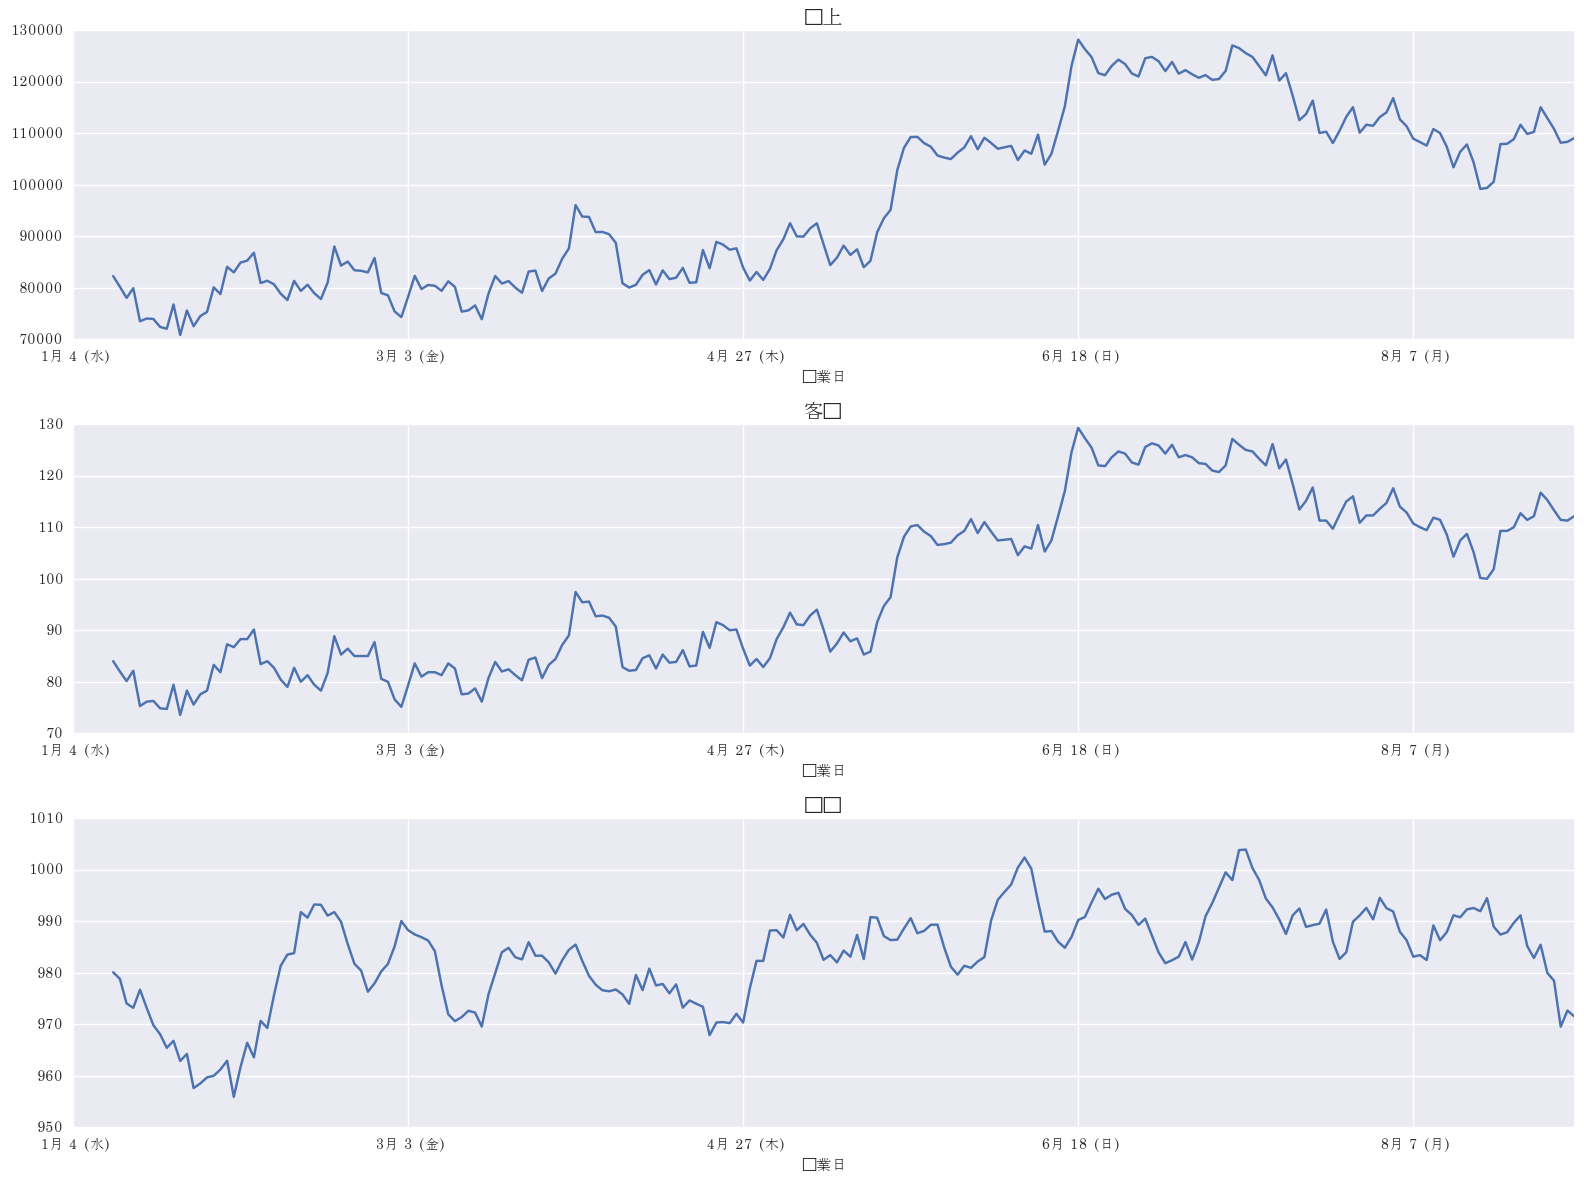

In [149]:
#2.時系列における売上（単価・来客数）の推移はどうなっているか。
#移動平均的で出す。
base_rolling = base.rolling(window=7, min_periods=7).mean() #14日の移動平均

graph_num = 3
fig, axes = plt.subplots(nrows=graph_num, ncols=1, figsize=(16,12),  squeeze=False) #squeezeはsubplotsのおまじない

for i, col in enumerate(base_rolling):
    base_rolling[col].plot(ax=axes[i,0])
    axes[i,0].set_title(col, fontsize=14, fontweight='bold')
    i+=1
    if i == graph_num:
        break
plt.tight_layout() #スペース調整

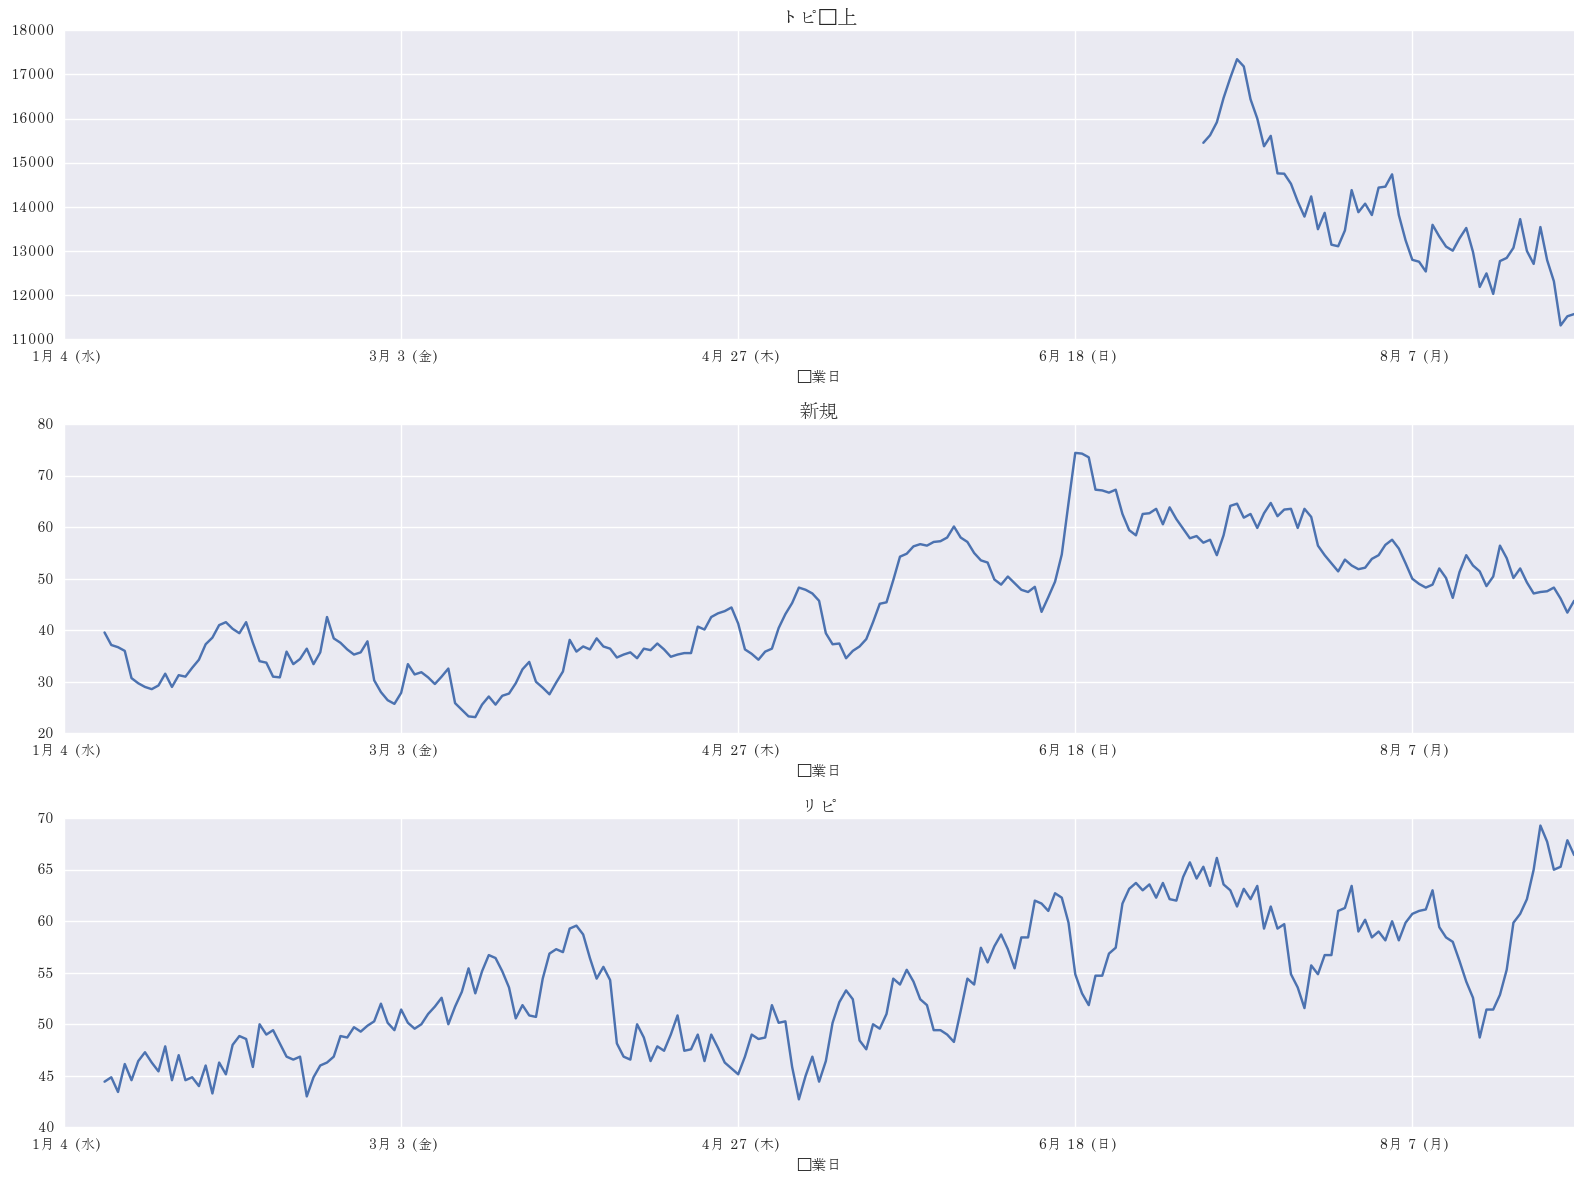

In [86]:
#移動平均的で出す。
plus_rolling = plus.rolling(window=7, min_periods=7).mean() #7日の移動平均

graph_num = 3
fig, axes = plt.subplots(nrows=graph_num, ncols=1, figsize=(16,12),  squeeze=False) #squeezeはsubplotsのおまじない

for i, col in enumerate(plus_rolling):
    plus_rolling[col].plot(ax=axes[i,0])
    axes[i,0].set_title(col, fontsize=14, fontweight='bold')
    i+=1
    if i == graph_num:
        break
plt.tight_layout() #スペース調整

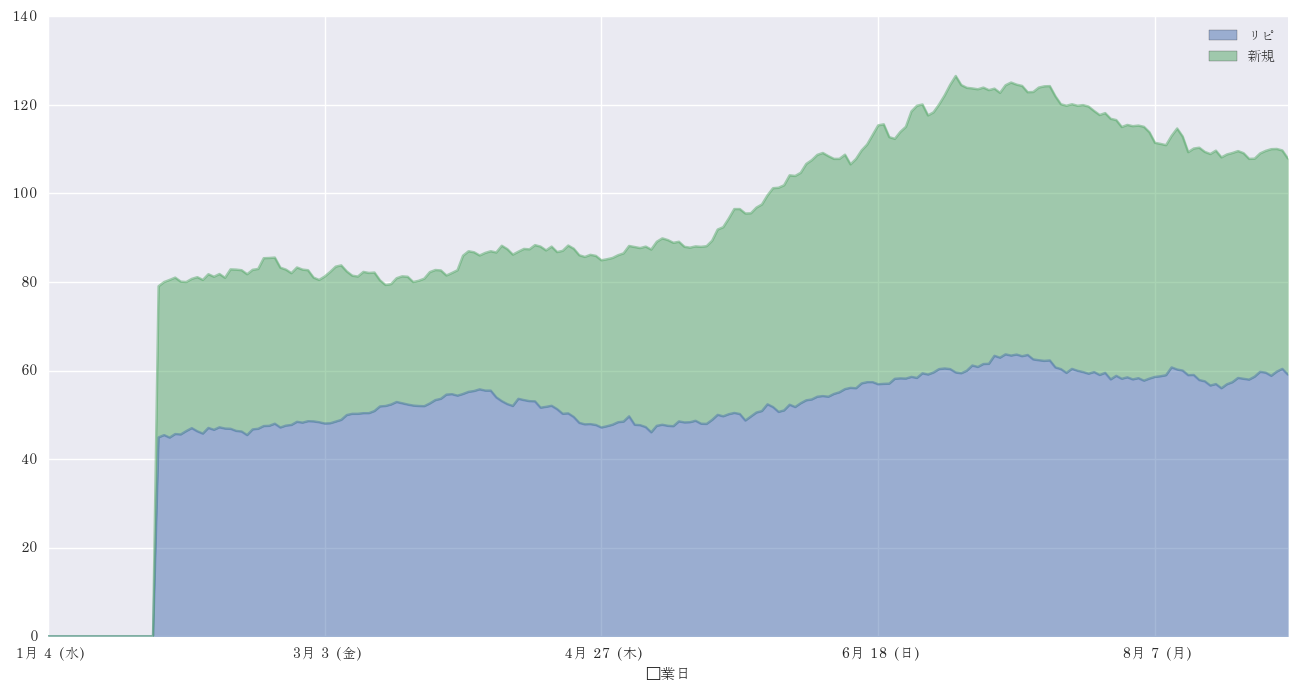

In [150]:
plus_rolling = plus.rolling(window=21, min_periods=21).mean() #7日の移動平均
plus_rolling.loc[:,['リピ','新規']].plot(
    legend=True, figsize=(16, 8), y=['リピ','新規']
          , kind='area', stacked=True, alpha=0.5
)

### 2.時系列における売上（単価・来客数）の推移はどうなっているか。
- 5月前半と6月中盤に強いプラススパイク（アド街と寿司記事効果）
- お盆, GWなど長期休みはリピーターが減る。TVに出るとリピーターは来るのを控える
- 単価はしばらくほとんど変わらず。メニューの変更などで改善していく必要あり。 *AI*
- TVのスパイクはやっぱり効果あるので用法用量を守ってもう少し柔軟に対応したほうがいいかも
    - 簡単にってところが気持ち悪いというのはかなりある。
    - ブログ記事で伸ばしたほうが正攻法感あるしあとで聞いてきそうってのもある
- とは言えそこまで強くリピーター獲得に貢献しているわけではなさそうなのが懸念点。

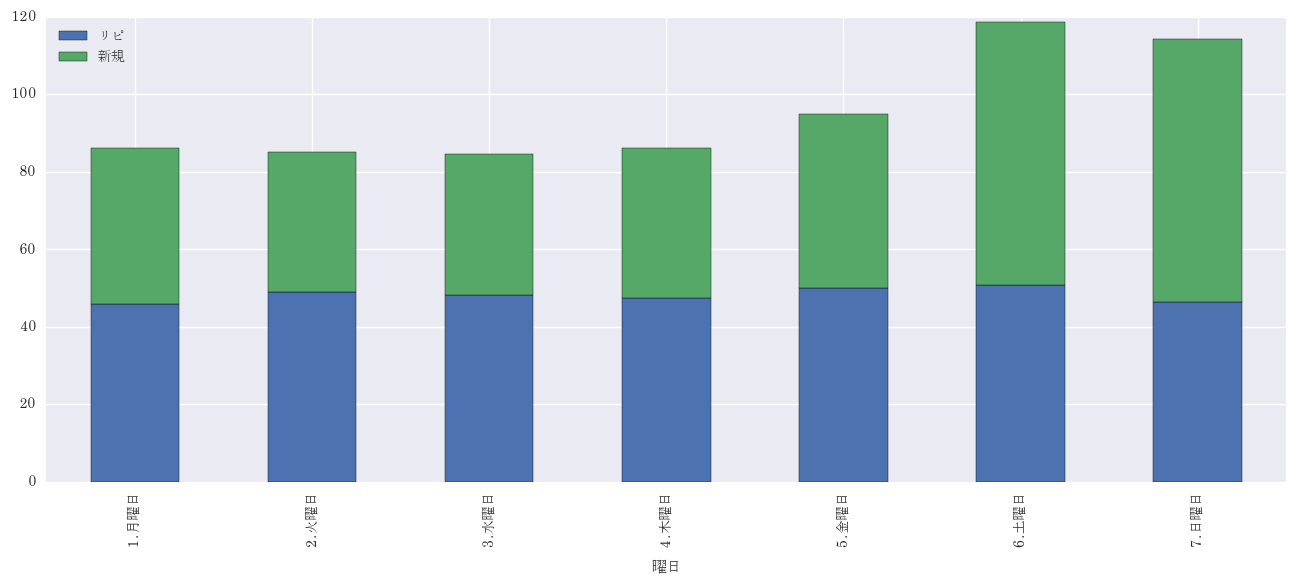

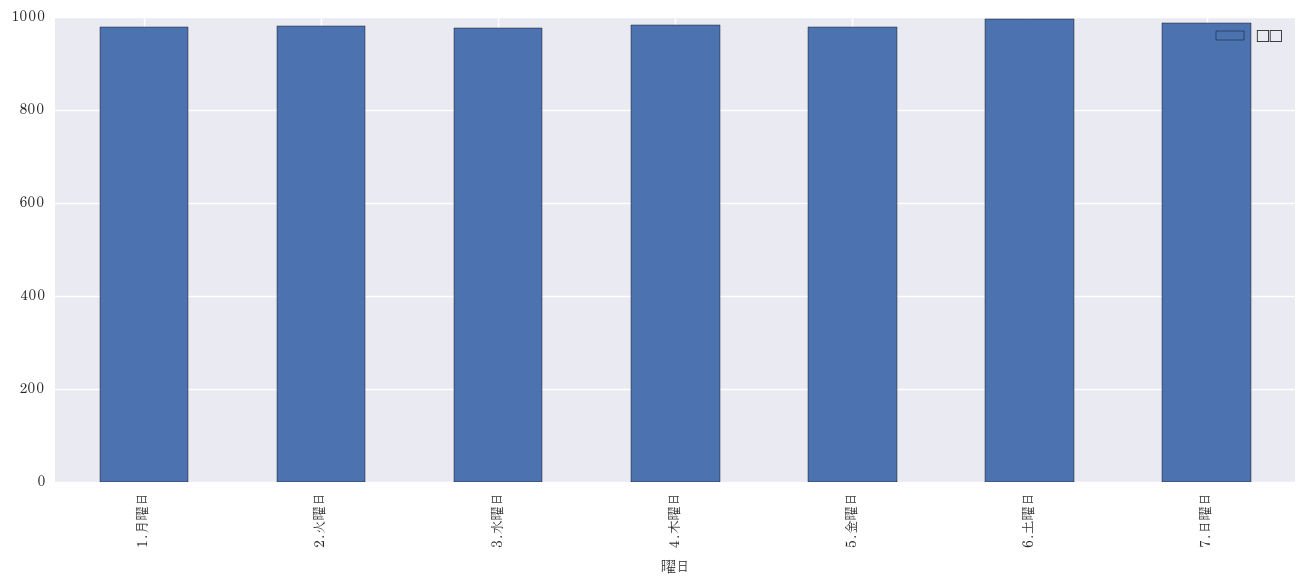

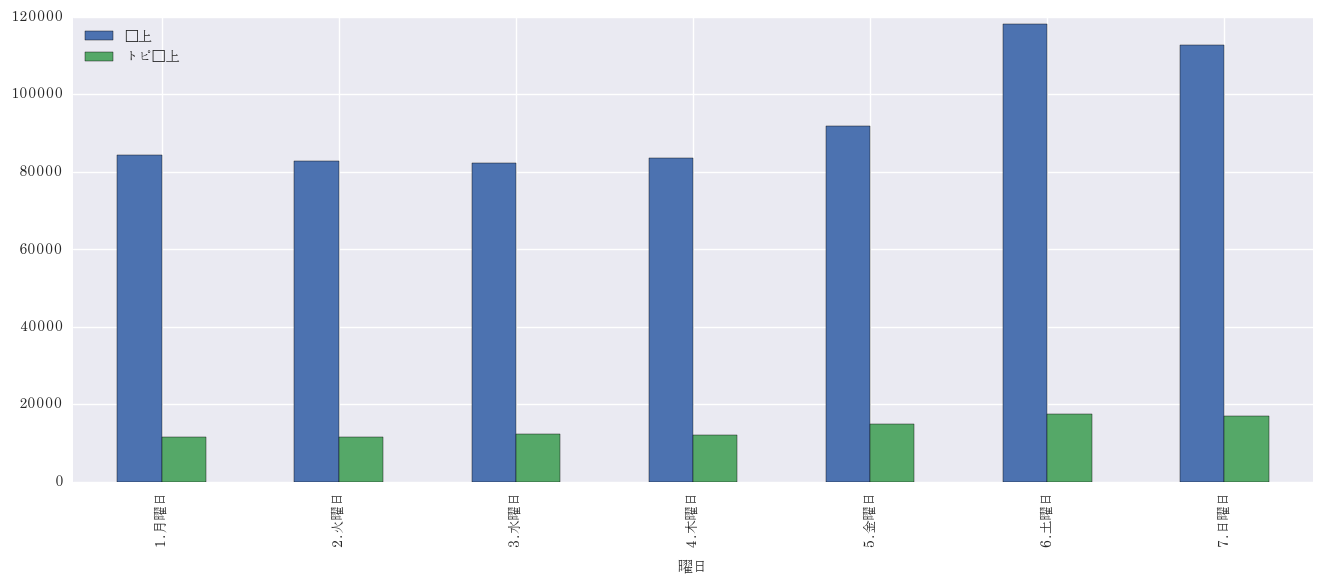

In [151]:
#各ディメンションごとの売上（単価・来客数）推移はどうなっているか。
#曜日ごとの客数
week_ctmr = data[['リピ','新規']].groupby(data['曜日'])
week_ctmr.mean().plot(legend=True, figsize=(16, 6), kind="bar", stacked=True)

week_unit = data[['単価']].groupby(data['曜日'])
week_unit.mean().plot(legend=True, figsize=(16, 6), kind="bar")

week_unit = data[['売上','トピ売上']].groupby(data['曜日'])
week_unit.mean().plot(legend=True, figsize=(16, 6), kind="bar", stacked=False)

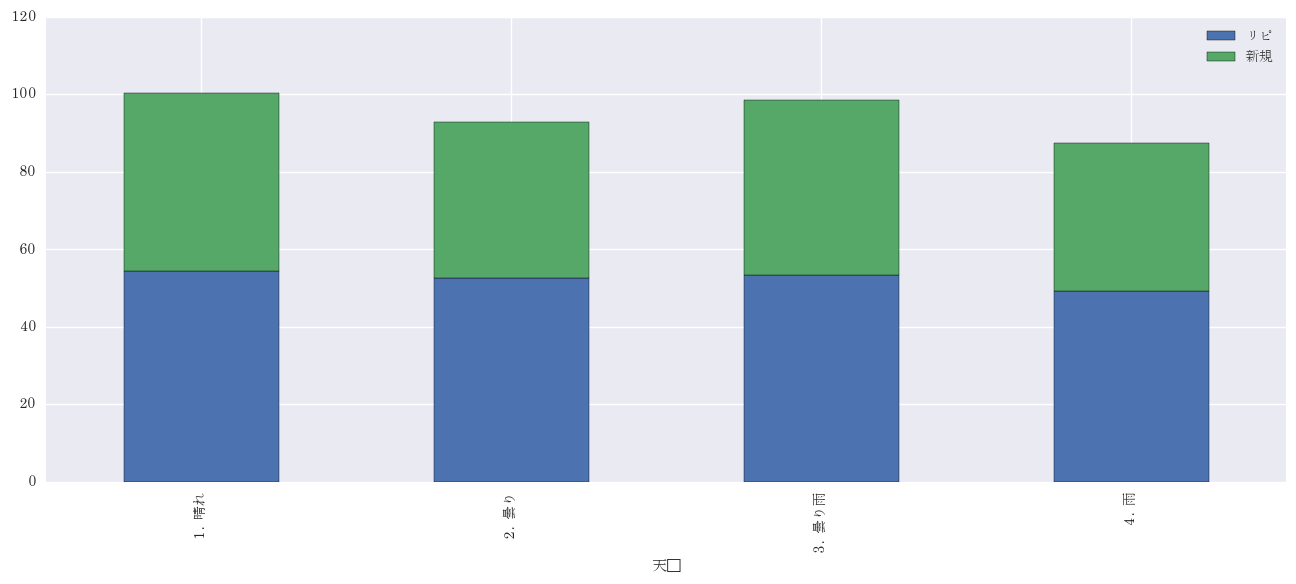

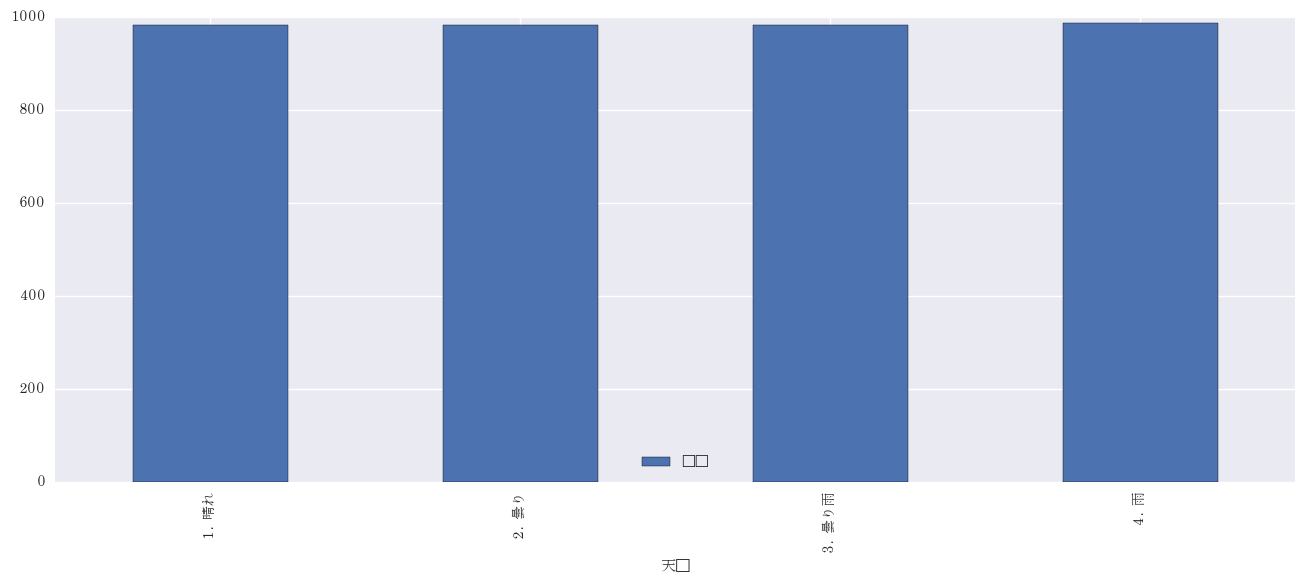

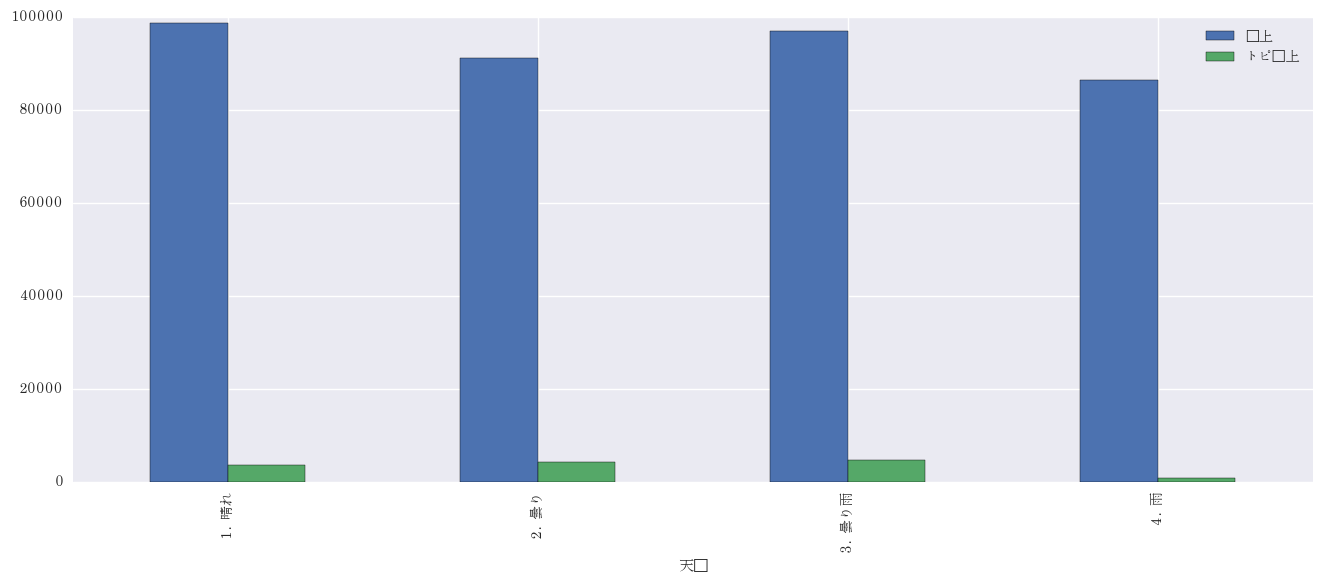

In [78]:
#天気ごとの客数
week_ctmr = data[['リピ','新規']].groupby(data['天気'])
week_ctmr.mean().plot(legend=True, figsize=(16, 6), kind="bar", stacked=True)

week_unit = data[['単価']].groupby(data['天気'])
week_unit.mean().plot(legend=True, figsize=(16, 6), kind="bar")

week_unit = data[['売上','トピ売上']].groupby(data['天気'])
week_unit.mean().plot(legend=True, figsize=(16, 6), kind="bar", stacked=False)

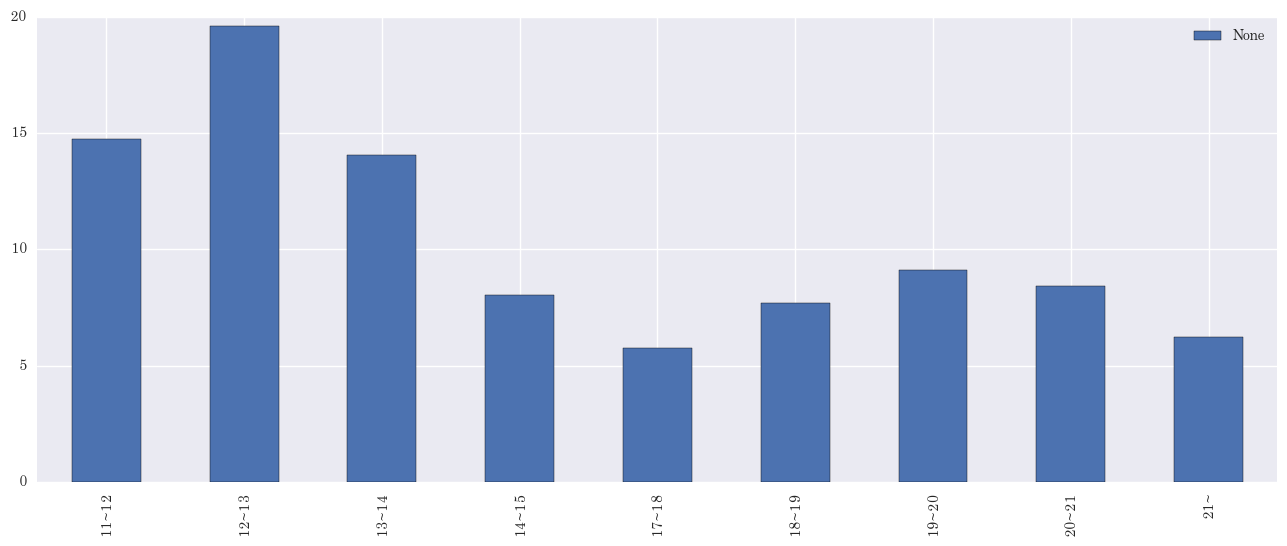

In [152]:
#時間ごと
time = data.loc[:,['11~12','12~13','13~14','14~15','17~18','18~19','19~20','20~21','21~']]
time.mean().plot(legend=True, figsize=(16, 6), kind="bar", stacked=False)

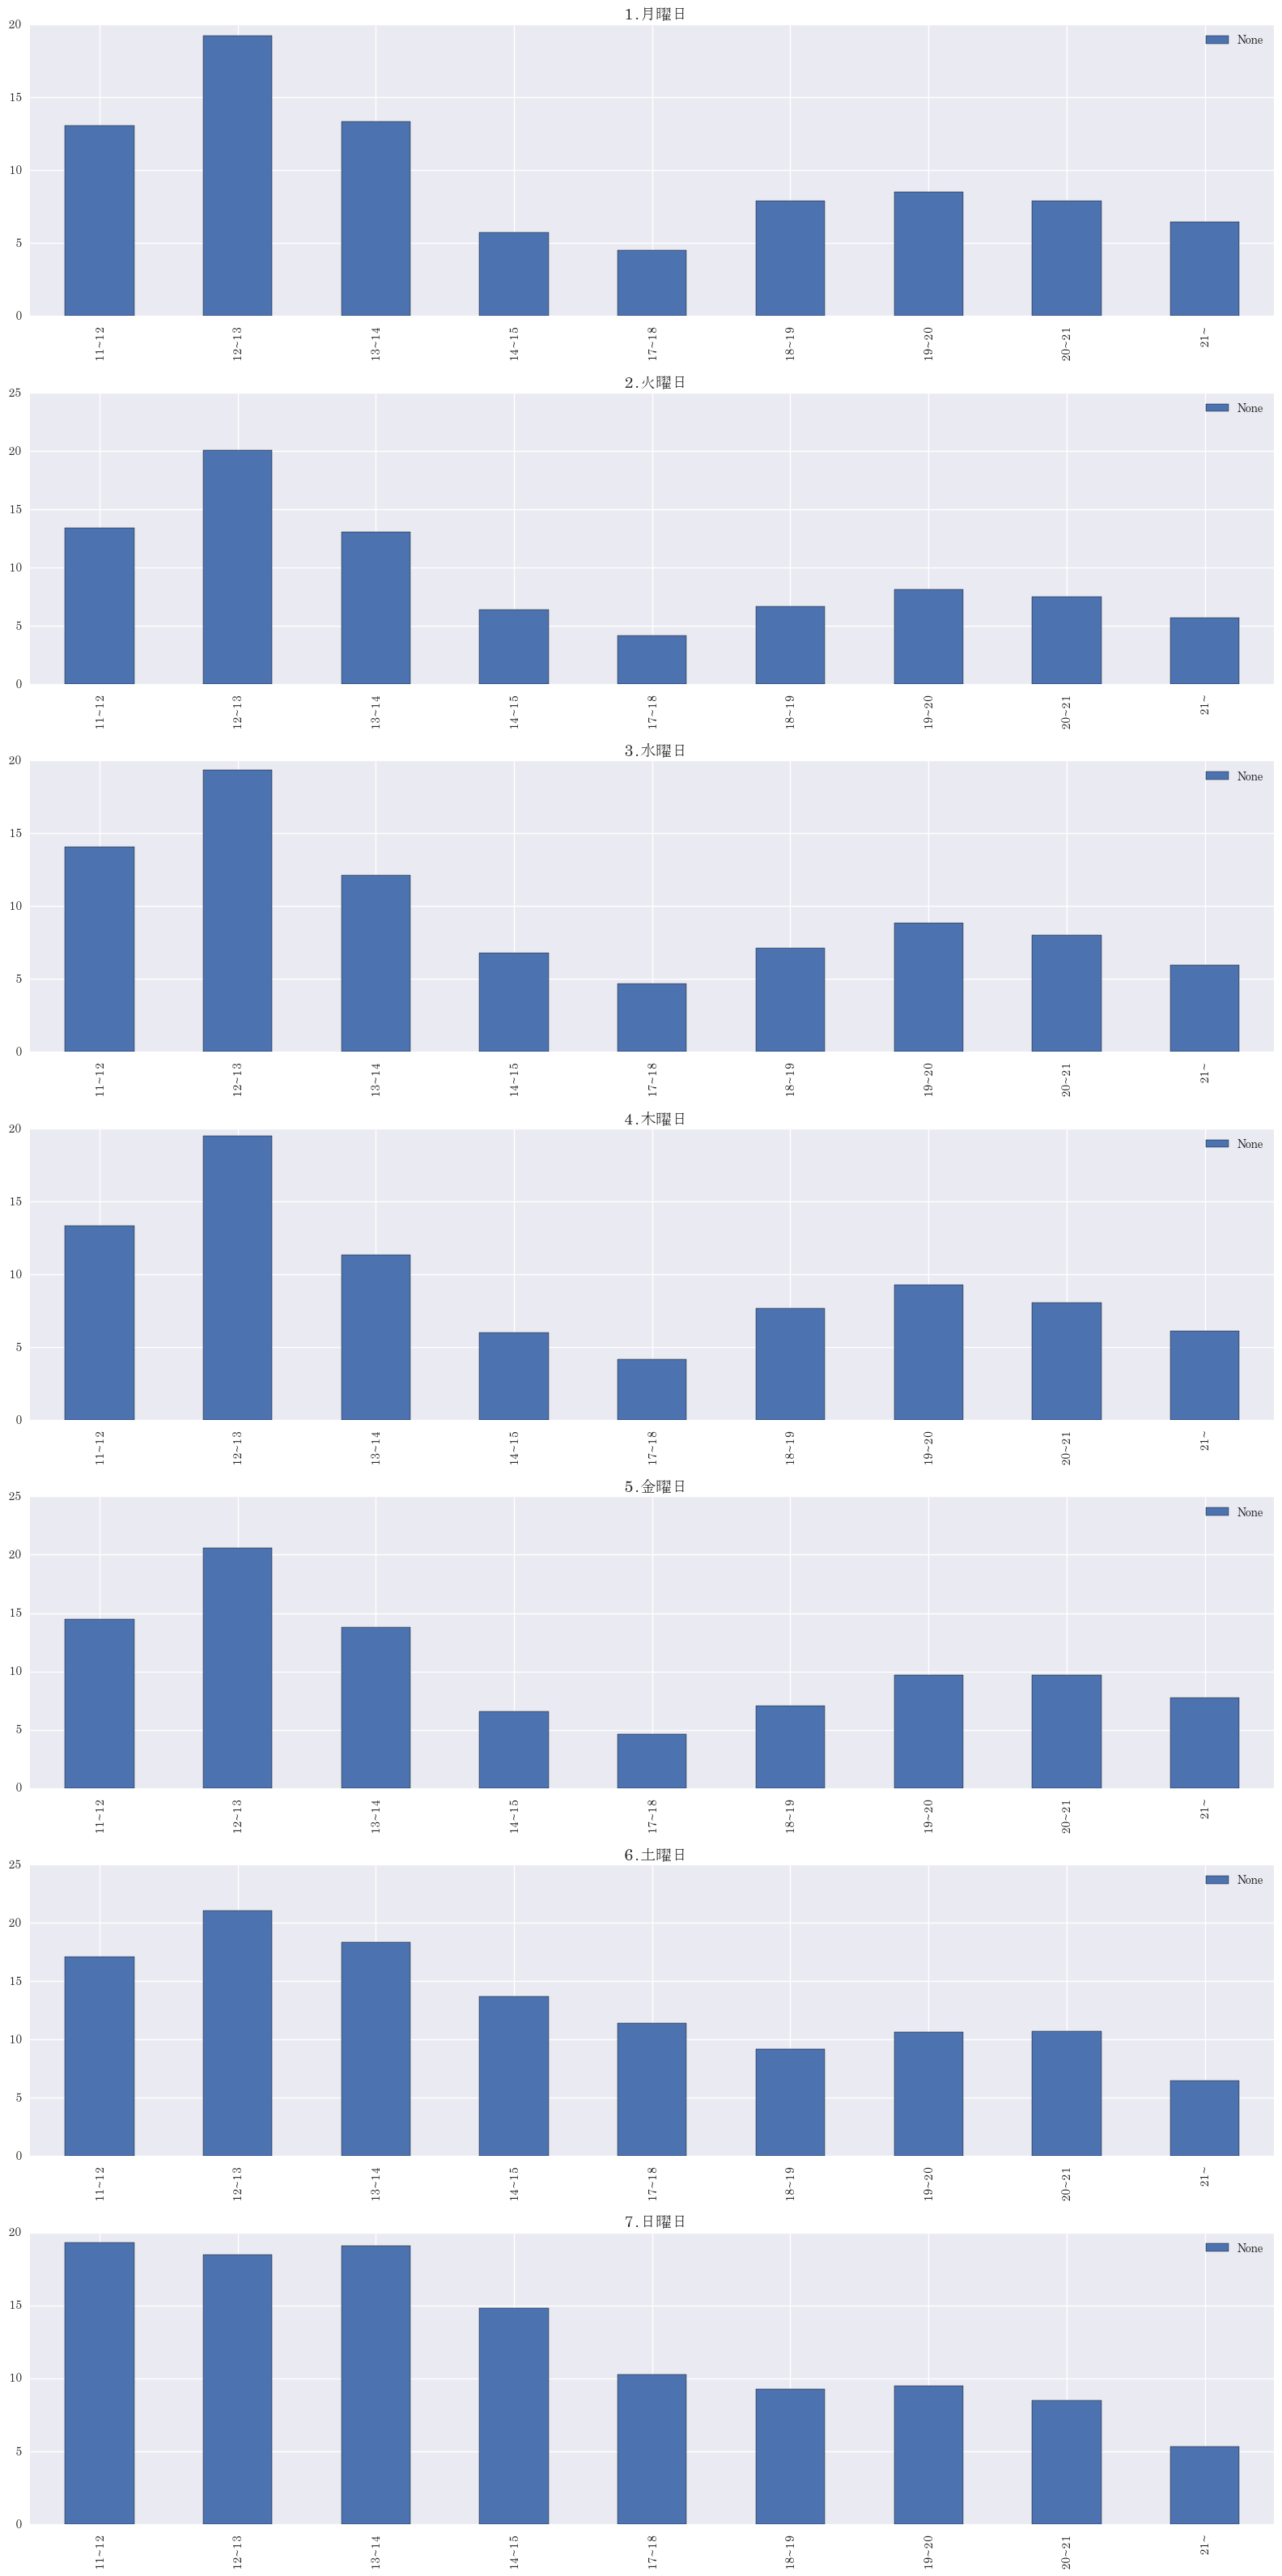

In [153]:
#時間と曜日ごと
time_week = data.loc[:,['11~12','12~13','13~14','14~15','17~18','18~19','19~20','20~21','21~','曜日']].dropna(subset=['11~12'])
#d = time_week.groupby('曜日')['11~12'].sum()
#d.plot(legend=True, figsize=(16, 4), kind="bar", stacked=True)
weeks = data.groupby('曜日')['曜日'].count().index

graph_num = 7
fig, axes = plt.subplots(nrows=graph_num, ncols=1, figsize=(16,32),  squeeze=False) #squeezeはsubplotsのおまじない

for i,w in enumerate(weeks):
    doa = time_week[time_week['曜日'] == w]   
    doa.mean().plot(legend=True, ax=axes[i,0], kind="bar", stacked=False)
    axes[i,0].set_title(w, fontsize=14, fontweight='bold')

plt.tight_layout() #スペース調整

